# Spike Detection Algorithm Analysis

Can we automatically detect when there's lots of positive or negative sentiment discussion in a subreddit on a particular day?

The goal of the this notebook is to identify "spikes" in the daily average sentiment score
- We care about both positive or negative spikes
- We want the "spike" to be significant relative to historical values

This notebook
- Walks through importing data from the HuggingFace dataset hub
- Compares a few different spike definitions based on rolling statistics
- Selects the best spike definition based on sanity checking against historical data

## Imports and Definitions

In [1]:
import os
import glob
import datetime
from pathlib import Path
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import pyarrow

from huggingface_hub import HfApi
from huggingface_hub.utils import disable_progress_bars

disable_progress_bars()  # turns off all HF progress bars

In [2]:
def load_reddit_data(folder='data_scored'):
    df = []
    repo_id = "hblim/top_reddit_posts_daily"
    api = HfApi()
    all_files = api.list_repo_files(repo_id, repo_type="dataset")
    parquet_files = sorted([f for f in all_files if f.startswith(folder) and f.endswith(".parquet")])

    for shard in parquet_files:
        local_path = api.hf_hub_download(repo_id=repo_id, filename=shard, repo_type="dataset")
        file_date = os.path.splitext(os.path.basename(local_path))[0]
        df.append(pd.read_parquet(local_path).assign(filedate=file_date))

    df = pd.concat(df, ignore_index=True)
    print(f"Total records across {df.filedate.nunique()} days: {len(df)}")
    return df

In [3]:
def summary_from_df(df: pd.DataFrame, gamma_post: float = 0.3) -> pd.DataFrame:
    """
    Return a DataFrame with daily & subreddit aggregates.

    Expects columns:
        retrieved_at  - UTC timestamp or ISO-date string
        subreddit     - subreddit name
        sentiment     - numeric score (e.g. −1 … 1)
        score         - numeric weight / post score

    Output columns:
        date               (datetime.date)
        subreddit          (string)
        community_weighted_sentiment
        count
    """
    # Normalize retrieved_at to datetime and extract calendar day
    df = df.copy()
    df["date"] = pd.to_datetime(df["retrieved_at"]).dt.date
    
    # Group by date and subreddit
    grouped = df.groupby(["date", "subreddit"])
    
    # Aggregate metrics
    result = grouped.agg(
        # First calculate raw mean_sentiment
        raw_mean_sentiment=("sentiment", "mean"),
        count=("sentiment", "count"),
    ).reset_index()
    
    # Apply transformation to raw_mean_sentiment to get values in range [-1, 1] instead of [0, 1]
    result["mean_sentiment"] = 2 * result["raw_mean_sentiment"] - 1
    
    # Remove the raw mean column
    result = result.drop(columns="raw_mean_sentiment")
    
    # Calculate engagement-adjusted sentiment (EAS) for each group
    # 1. Ensure 'score' is numeric
    df["score_num"] = pd.to_numeric(df["score"], errors="coerce").fillna(0)
    # 2. Compute base weights (1 + log1p(score))
    weights_base = 1 + np.log1p(df["score_num"].clip(lower=0))
    # 3. Apply post weight multiplier
    weights = weights_base * np.where(df.get("type", None) == "post", gamma_post, 1.0)
    df["weight"] = weights
    # 4. Compute EAS per group: weighted average of sentiment
    community_weighted_sentiments = []
    for (date, subreddit), group in grouped:
        w = group["weight"]
        s = group["sentiment"]
        eas = (w * s).sum() / w.sum() if w.sum() > 0 else 0
        community_weighted_sentiments.append(eas)
    result["community_weighted_sentiment"] = community_weighted_sentiments
    
    # Normalize community_weighted_sentiment to range [-1,1]
    result["community_weighted_sentiment"] = 2 * result["community_weighted_sentiment"] - 1
    
    # Ensure consistent column order
    result = result[["date", "subreddit", "community_weighted_sentiment"]]
    
    return result

In [4]:
df = load_reddit_data()

Total records across 258 days: 82180


In [5]:
df_summary = summary_from_df(df).set_index('date',drop=True)
df_summary.head(8)

subreddit  community_weighted_sentiment
date                                                 
2025-05-01   LocalLLaMA                     -0.477880
2025-05-01       OpenAI                     -0.516990
2025-05-01   artificial                     -0.506502
2025-05-01  singularity                     -0.435683
2025-05-02   LocalLLaMA                     -0.434680
2025-05-02       OpenAI                     -0.487859
2025-05-02   artificial                     -0.504200
2025-05-02  singularity                     -0.415097

## Analysis to Determine Spike Metric

### Method 1: Calculate Z-score based on mean and std of prior week

Use prior week mean and std

In [184]:
rolling = df_summary.groupby('subreddit')[['community_weighted_sentiment']].rolling(7)
mean_cws = rolling.mean().groupby('subreddit').shift(1).reset_index().rename(columns={'community_weighted_sentiment': 'mean_cws'})
std_cws = rolling.std().groupby('subreddit').shift(1).reset_index().rename(columns={'community_weighted_sentiment': 'std_cws'})

In [185]:
df_history = df_summary.merge(mean_cws,how='outer',on=['date','subreddit']).merge(std_cws,how='outer',on=['date','subreddit'])
df_history['z_score'] = (df_history.community_weighted_sentiment - df_history.mean_cws) / df_history.std_cws

In [186]:
df_zscores = df_history.pipe(pd.pivot_table, index='date',columns='subreddit',values='z_score',aggfunc="max")

def highlight_abs_gt_3(val):
    return 'background-color: red' if abs(val) > 3 else ''

styled = df_zscores.style.map(highlight_abs_gt_3)

styled

Looking at the June 22 spike, it's suspicious we found an 8.7 sigma spike
- The prior week (6/15 -- 6/21) had a smaller std, which suddenly dropped to 0.019 from 0.1 ish
- This caused the current day's -0.25 score to look really spikey

However, based on the data beyond just the prior week, the -.25 score is not that significant! See plenty of values near -0.2 prior to that week

Therefore is probably not a huge spike to alert on, so we need a more stable std calculation.

In [187]:
date = "2025-06-22"
subreddit = "singularity"

rightwindow = datetime.datetime.strptime(date,"%Y-%m-%d").date()
leftwindow = rightwindow - datetime.timedelta(days=15)


fil = lambda x: x.date.between(leftwindow,rightwindow) & (x.subreddit == subreddit)

df_history[fil]

date    subreddit  community_weighted_sentiment  mean_cws  \
151  2025-06-07  singularity                     -0.352707 -0.425644   
155  2025-06-08  singularity                     -0.493835 -0.411582   
159  2025-06-09  singularity                     -0.482524 -0.412734   
163  2025-06-10  singularity                     -0.416534 -0.407614   
167  2025-06-11  singularity                     -0.358953 -0.392952   
171  2025-06-12  singularity                     -0.308392 -0.401512   
175  2025-06-13  singularity                     -0.258518 -0.393909   
179  2025-06-14  singularity                     -0.169175 -0.381637   
183  2025-06-15  singularity                     -0.392046 -0.355419   
187  2025-06-16  singularity                     -0.389244 -0.340877   
191  2025-06-17  singularity                     -0.432632 -0.327552   
195  2025-06-18  singularity                     -0.430223 -0.329851   
199  2025-06-19  singularity                     -0.426679 -0.340033   
203  2025-06-20  singularity                     -0.434163 -0.356931   
207  2025-06-21  singularity                     -0.415414 -0.382023   
211  2025-06-22  singularity                     -0.250397 -0.417200   

      std_cws   z_score  
151  0.089756  0.812612  
155  0.092756 -0.886763  
159  0.093874 -0.743442  
163  0.087944 -0.101424  
167  0.073637  0.461712  
171  0.063714  1.461535  
175  0.071916  1.882643  
179  0.087425  2.430223  
183  0.119269 -0.307101  
187  0.104923 -0.460972  
191  0.088586 -1.186198  
195  0.091444 -1.097628  
199  0.098889 -0.876198  
203  0.102617 -0.752625  
207  0.095790 -0.348584  
211  0.019161  8.705383

<Axes: xlabel='date', ylabel='sentiment score'>

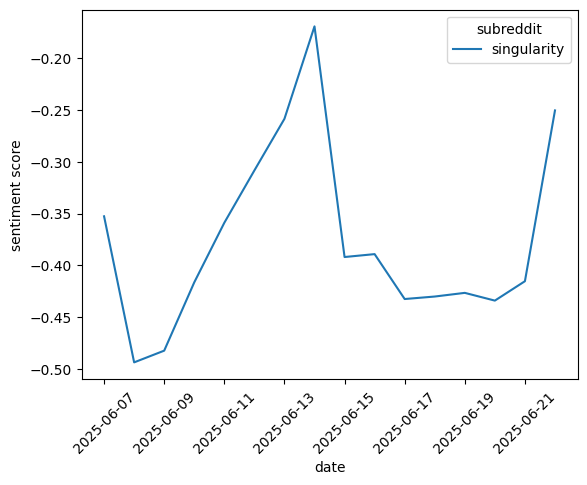

In [188]:
df_history[fil].pipe(pd.pivot_table,index='date',values='community_weighted_sentiment',columns=['subreddit'],aggfunc='max').plot(rot=45,ylabel='sentiment score')

### Method 2: Calculate z-score based on the mean and std of entire May's data

In [6]:
global_stats = (df_summary[pd.to_datetime(df_summary.index).month == 5]
                .groupby('subreddit').agg(mean_cws=('community_weighted_sentiment','mean'),
                                          std_cws=('community_weighted_sentiment','std')
                                          )
               )
global_stats

mean_cws   std_cws
subreddit                      
LocalLLaMA  -0.485437  0.069627
OpenAI      -0.493694  0.071395
artificial  -0.473540  0.138909
singularity -0.429887  0.081146

In [7]:
df_summary[['mean_cws','std_cws']] = global_stats.loc[df_summary.subreddit,['mean_cws','std_cws']].values
df_history = df_summary.copy().reset_index()
df_history['z_score'] = (df_history.community_weighted_sentiment - df_history.mean_cws) / df_history.std_cws

In [8]:
df_zscores = df_history.pipe(pd.pivot_table, index='date',columns='subreddit',values='z_score',aggfunc="max")

def highlight_abs_gt_3(val):
    return 'background-color: red' if abs(val) > 3 else ''

styled = df_zscores.style.map(highlight_abs_gt_3)

styled

With the more stable mean and std calculation, seems like we've found an actual spike

In [9]:
date = "2025-05-29"
subreddit = "artificial"

rightwindow = datetime.datetime.strptime(date,"%Y-%m-%d").date()
leftwindow = rightwindow - datetime.timedelta(days=15)


fil = lambda x: x.date.between(leftwindow,rightwindow) & (x.subreddit == subreddit)

df_history[fil]

date   subreddit  community_weighted_sentiment  mean_cws   std_cws  \
54   2025-05-14  artificial                     -0.536738  -0.47354  0.138909   
58   2025-05-15  artificial                     -0.627437  -0.47354  0.138909   
62   2025-05-16  artificial                     -0.578293  -0.47354  0.138909   
66   2025-05-17  artificial                     -0.508196  -0.47354  0.138909   
70   2025-05-18  artificial                     -0.498451  -0.47354  0.138909   
74   2025-05-19  artificial                     -0.552404  -0.47354  0.138909   
78   2025-05-20  artificial                     -0.425843  -0.47354  0.138909   
82   2025-05-21  artificial                     -0.628255  -0.47354  0.138909   
86   2025-05-22  artificial                     -0.690261  -0.47354  0.138909   
90   2025-05-23  artificial                     -0.323495  -0.47354  0.138909   
94   2025-05-24  artificial                     -0.332641  -0.47354  0.138909   
98   2025-05-25  artificial                     -0.380308  -0.47354  0.138909   
102  2025-05-26  artificial                     -0.274642  -0.47354  0.138909   
106  2025-05-27  artificial                     -0.683447  -0.47354  0.138909   
110  2025-05-28  artificial                     -0.480826  -0.47354  0.138909   
114  2025-05-29  artificial                     -0.008654  -0.47354  0.138909   

      z_score  
54  -0.454956  
58  -1.107901  
62  -0.754111  
66  -0.249486  
70  -0.179333  
74  -0.567740  
78   0.343371  
82  -1.113788  
86  -1.560167  
90   1.080172  
94   1.014332  
98   0.671174  
102  1.431861  
106 -1.511113  
110 -0.052449  
114  3.346702

<Axes: xlabel='date', ylabel='sentiment score'>

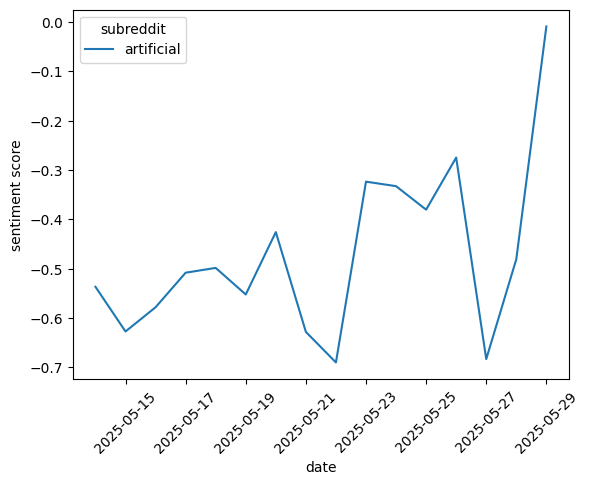

In [10]:
df_history[fil].pipe(pd.pivot_table,index='date',values='community_weighted_sentiment',columns=['subreddit'],aggfunc='max').plot(rot=45,ylabel='sentiment score')

## Export Spike Metric to Production

In [15]:
import yaml

params = {
    sub: {
        "mean": round(float(row["mean_cws"]), 4),   # float() strips NumPy dtype
        "std":  round(float(row["std_cws"]), 4),
    }
    for sub, row in global_stats.iterrows()
}

with open("../spike_params.yaml", "w", encoding="utf-8") as f:
    f.write("# spike_params.yaml\n")
    yaml.safe_dump(params, f, sort_keys=False, default_flow_style=False)